#Libraries

In [3]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.9 MB/s 


In [4]:
# Data managment 
from google.colab import drive
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA

# Machine learning models
import sklearn 
from sklearn.linear_model import ElasticNetCV

#Feature selection
from sklearn.feature_selection import f_regression, mutual_info_regression

# Evalutation metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

# statistic tests
import operator
#from scipy.stats import f, t
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, kstest, boxcox

# feature interpretation
import shap

# Others
import warnings 
warnings.filterwarnings('ignore')
import random

#Data loading

In [5]:
from scipy.special import lmbda
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/AI_CHEMENG/Final Project')
# Load data
feature_names = ['PERCENT_ACTIVE', 'EFF_TORTUOSITY', 'POROSITY', 'RXNK', 'VFRAC_AM_PERCENT','LENGTH', 'CRATE', 'DIFF_BULK']

target_name = ['ENERGY']
data = np.load('DATASET_30/INPUT_DATA_30.npy')
target = np.load('DATASET_30/TARGET_DATA_30.npy')

# Data dimensions
COL_N = data.shape[1]
print('input shape: ', data.shape)
print('target shape: ', target.shape)
data2 = data.copy()
data2[: ,1] = boxcox(np.abs(data[: ,1]), lmbda = 0)
data2[: ,4] = boxcox(np.abs(data[: ,4]), lmbda = 0)
data2[: ,6] = boxcox(np.abs(data[: ,6]), lmbda = -1)
data2[: ,7] = boxcox(np.abs(data[: ,7]), lmbda = 0)
# Standardized data
first_scaled_X = (data2 - np.mean(data2, axis = 0)) / np.std(data2, axis = 0)

# Dataframe format
df_1 = pd.DataFrame(first_scaled_X, columns = feature_names)
df_1['ENERGY'] = target

Mounted at /content/gdrive
input shape:  (1087, 8)
target shape:  (1087,)


In [7]:
# Check if there is any outlier in each feature and remove them
def outliers(dataset, n):
  out_i = []
  for col in range(COL_N):
      quar1 = np.percentile(dataset[:, col],25)
      quar3 = np.percentile(dataset[:, col],75)
      quar = quar3-quar1
      outlier_step = 1.5 * quar 

      for i in range(data.shape[0]):
        
        if (dataset[i, col] < quar1 - outlier_step) or (dataset[i, col] > quar3 + outlier_step):
          out_i.append(i)
          
  out_i = Counter(out_i)
  multiple_outliers = list(key for key, value in out_i.items() if value > n) 
  return multiple_outliers

outliers_to_drop = outliers(first_scaled_X, 2)
# scaled_X, = np.delete(scaled_X,, outliers_to_drop , 0)
print('outliers in unadjusted dataset: ', len(outliers_to_drop))

outliers in unadjusted dataset:  0


#Data Visualization

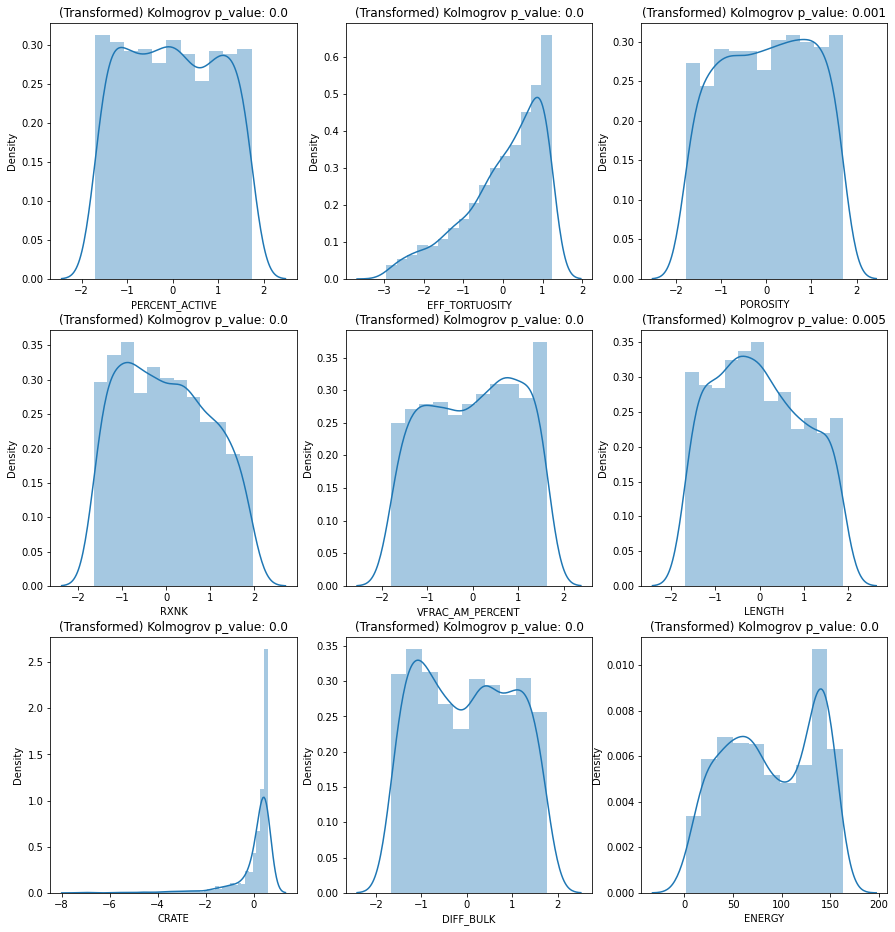

In [331]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15,16)

for i in range(3):
  for j in range(3):
    n = i*3 + (j+1) - 1
    if n == 8:
      sns.distplot(target, ax = ax[i, j])
      ax[i, j].set_xlabel(target_name[0]) 
      kp = kstest(target, 'norm')[1]
      title = '(Transformed) Kolmogrov p_value: ' + str(round(kp, 3))
      ax[i, j].set_title(title)
      break
    sns.distplot(first_scaled_X[:, n], ax = ax[i, j])
    ax[i, j].set_xlabel(feature_names[n]) 
    kp = kstest(first_scaled_X[:, n], 'norm')[1]
    title = '(Transformed) Kolmogrov p_value: ' + str(round(kp, 3))
    ax[i, j].set_title(title)

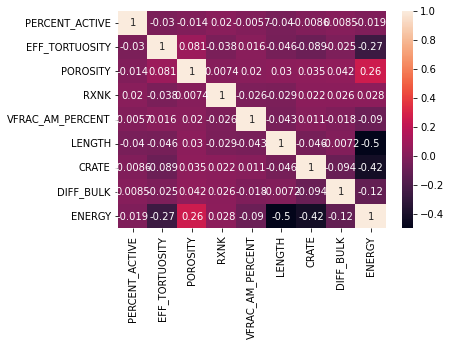

In [333]:
# Check no multicollinearity (no correlation b/w independent variables)
corr_matrix = df_1.corr()
sns.heatmap(corr_matrix, annot=True)

In [322]:
model = ols('ENERGY ~ PERCENT_ACTIVE + EFF_TORTUOSITY + POROSITY + RXNK + VFRAC_AM_PERCENT + LENGTH + CRATE+ DIFF_BULK', data = df_1).fit()
durbin_watson(model.resid)

2.0718319222056616

#Task 1: Data Preprocessing/ Cleaning


Need 8 vectors for at least 90% coverage


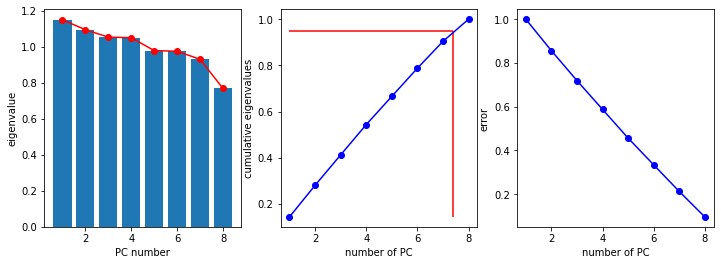

In [334]:
'''
PCA 
'''
def plot_PCA_bar(scaled_X):
  fig, ax = plt.subplots(1,3)
  fig.set_size_inches(12, 4)

  n = len(scaled_X)
  # scaled_X.T @ scaled_X / n is the covariance matrix of scaled_X
  U, S, Vh = np.linalg.svd(scaled_X.T @ scaled_X / n)

  errors = []
  for i in range(COL_N):
    U_reduced = U[:, :i]
    Z = scaled_X @ U_reduced
    X_approx = Z @ U_reduced.T
    error = np.sum(np.square(np.linalg.norm(scaled_X - X_approx, ord = 2, axis = 1))) / np.sum(np.square(np.linalg.norm(scaled_X, ord = 2, axis = 1)))
    errors.append(error)

  pca = PCA()
  pca.fit(scaled_X)
  evr_cum = np.cumsum(pca.explained_variance_ratio_)
  #evr_cum = np.cumsum(S) doesn't scaled to percentage
  # threshold will be: 90% variance explained with 8 variables => 0.9 = sum(lambda)/ 8 => sum(lambda) = 7.2

  # percent of coverage
  a = 0.95 
  m = 0
  for i in range(COL_N):
    if evr_cum[i] >= a:
      print("Need %d vectors for at least 90%% coverage" %(i+1))
      m = i+1
      break

  ax[0].set_ylabel("eigenvalue")
  ax[0].set_xlabel("PC number")
  ax[0].plot(np.linspace(1,COL_N, COL_N), S , 'ro-')
  ax[0].bar([ i +1 for i in range(COL_N)], S)
  ax[1].set_ylabel("cumulative eigenvalues")
  ax[1].set_xlabel("number of PC")
  xmax = 7.4
  ax[1].hlines(y = a, xmin = 1, xmax = xmax, color='r')
  ax[1].vlines(x = xmax, ymin = np.min(evr_cum), ymax = a ,color='r')
  ax[1].plot(np.linspace(1, COL_N, COL_N), evr_cum, 'bo-')
  ax[2].set_ylabel("error")
  ax[2].set_xlabel("number of PC")
  ax[2].plot(np.linspace(1, COL_N, COL_N), errors, 'bo-')

  return pca
pca = plot_PCA_bar(first_scaled_X)

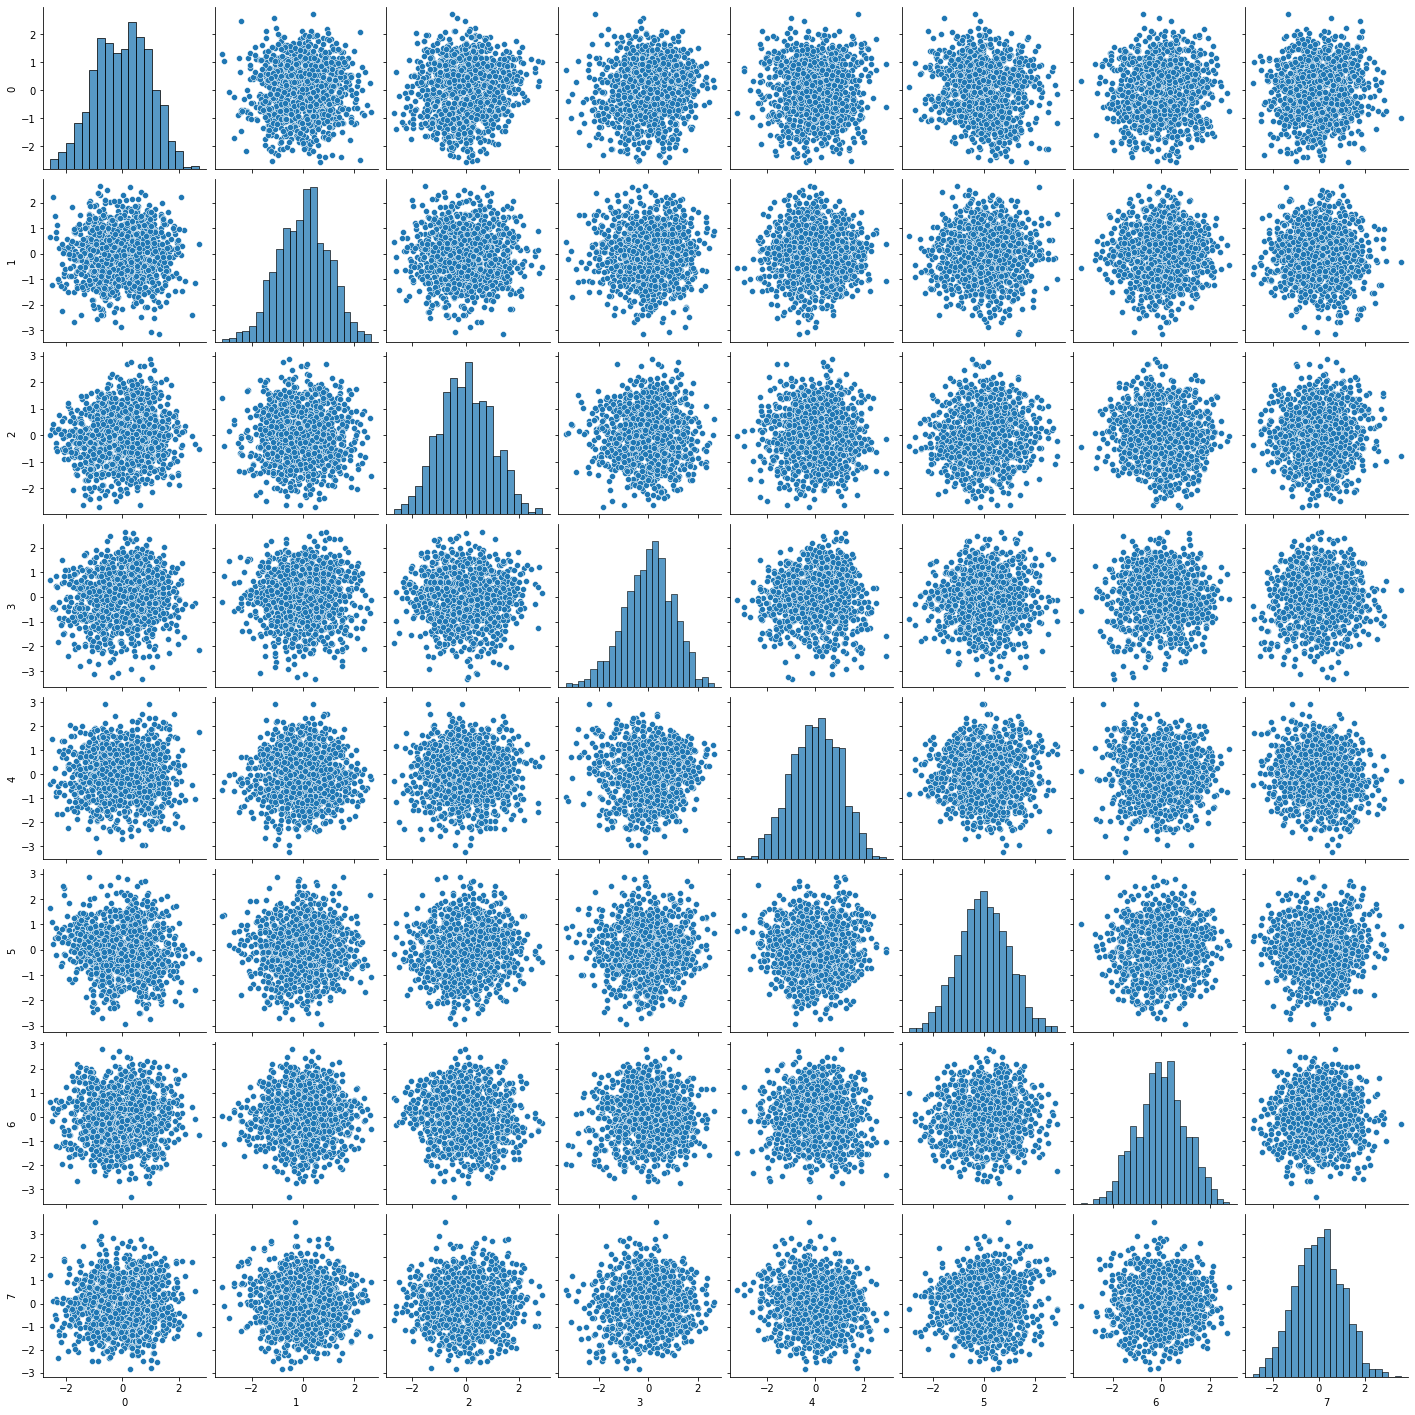

In [326]:
P = np.dot(first_scaled_X, pca.components_)
sns.pairplot(pd.DataFrame(P))

#Task 2: Model training

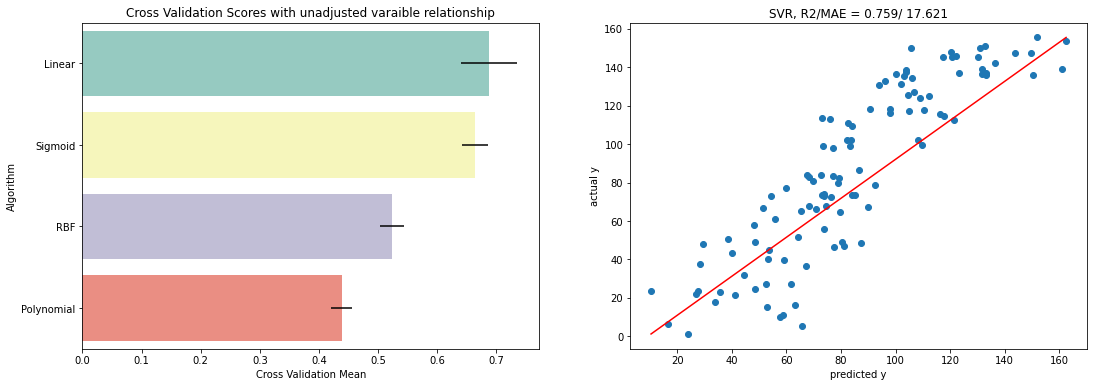

In [338]:
'''
SVR model with scaled_X
'''
def plot_svr(train_x, test_x, train_y, test_y):
# Setting up plots
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(18, 6)

  linear = sklearn.svm.SVR(kernel = 'linear')
  poly = sklearn.svm.SVR(kernel = 'poly')
  sig = sklearn.svm.SVR(kernel = 'sigmoid')
  rbf = sklearn.svm.SVR(kernel = 'rbf')

  regrs = [linear, poly, sig, rbf]
  # Get CV evalutation to tune SVR kernel
  cvs = []
  for regr in regrs:
      cvs.append(cross_val_score(regr, train_x, train_y, cv = 9, scoring = 'r2'))

  cvs = np.array(cvs)
  cvs_mean = np.mean(cvs, axis = 1)
  cvs_std = np.std(cvs, axis = 1)

  cv_res = pd.DataFrame({'Cross Validation Mean': cvs_mean, 'Cross Validation Std': cvs_std, 'Algorithm': ['Linear', 'Polynomial', 'Sigmoid', 'RBF']})
  cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)
  # Plot average error metrics of each kernel
  sns.barplot('Cross Validation Mean', 'Algorithm', ax = ax[0], data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cvs_std})
  ax[0].set_ylabel('Algorithm')
  ax[0].set_title('Cross Validation Scores with unadjusted varaible relationship')

  # Plot the performance of the trained model with linear kernel
  linear = sklearn.svm.SVR(kernel = 'linear')
  linear.fit(train_x, train_y)
  score = linear.score(test_x, test_y)
  yhat = linear.predict(test_x)
  mae = mean_absolute_error(test_y, yhat)
  ax[1].scatter(yhat, test_y)
  ax[1].plot(np.linspace(np.min(yhat), np.max(yhat)), np.linspace(np.min(test_y), np.max(test_y)), color ='r')
  ax[1].set_title('SVR'+ ', R2/MAE = %.3f/ %.3f' % (score, mae))
  ax[1].set_ylabel('actual y')
  ax[1].set_xlabel('predicted y')

# split data to train, validation, test sets
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(first_scaled_X, target, test_size = 0.1, random_state = 0)

plot_svr(train_x, test_x, train_y, test_y)

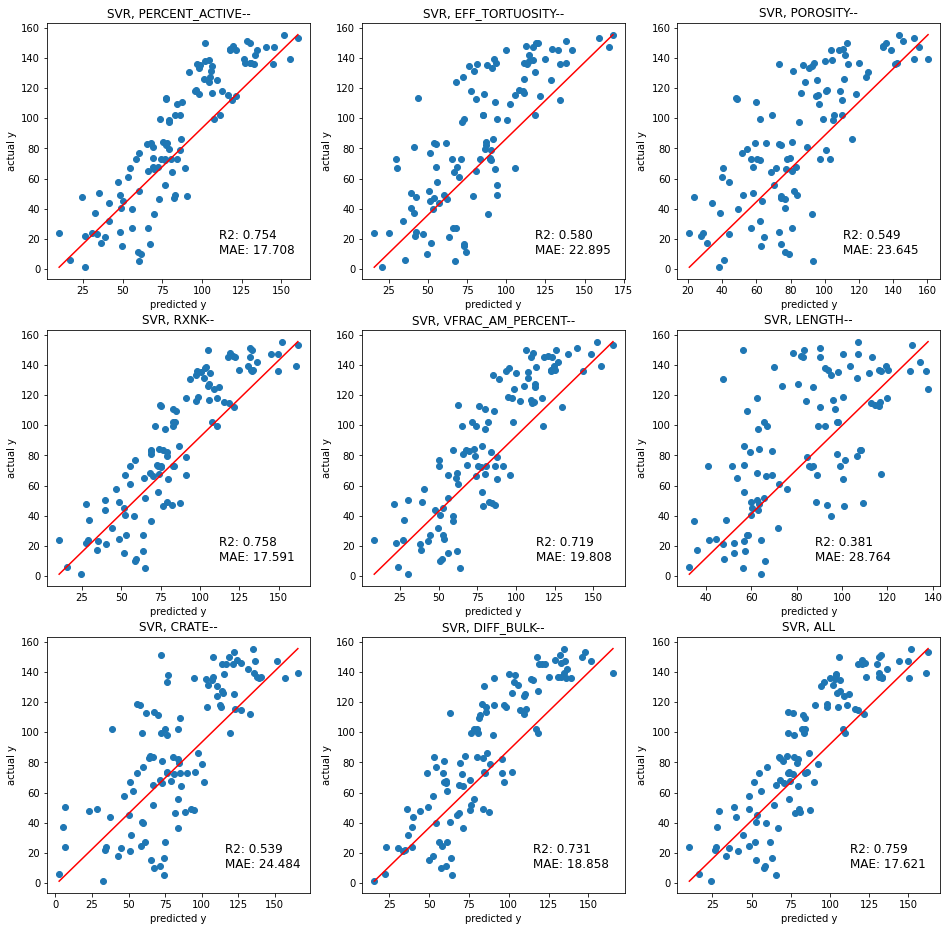

In [340]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(16, 16)

for i in range(3):
  for j in range(3):
    n = 3*i + j
    if n > COL_N - 1:
      train = train_x.copy()
      test = test_x.copy()
      ax[i, j].set_title('SVR, ALL')
    else:
      train = np.delete(train_x, n , 1)
      test = np.delete(test_x, n , 1)
      ax[i, j].set_title('SVR, %s--' %feature_names[n])


    linear = sklearn.svm.SVR(kernel = 'linear')
    linear.fit(train, train_y)
    score = linear.score(test, test_y)
    yhat = linear.predict(test)
    mae = mean_absolute_error(test_y, yhat)

    ax[i, j].scatter(yhat, test_y)
    ax[i, j].plot(np.linspace(np.min(yhat), np.max(yhat)), np.linspace(np.min(test_y), np.max(test_y)), color ='r')
    ax[i, j].set_ylabel('actual y')
    ax[i, j].set_xlabel('predicted y')
    ax[i, j].text(np.max(yhat) - 50, 10, 'R2: %.3f\nMAE: %.3f' % (score, mae), fontsize=12)

#Task 3: Data interpretation

In [341]:
svr_model = sklearn.svm.SVR(kernel = 'linear')
svr_model.fit(train_x, train_y)

explainer = shap.KernelExplainer(svr_model.predict, train_x)
shap_values = explainer.shap_values(test_x)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], feature_names)

  0%|          | 0/109 [00:00<?, ?it/s]

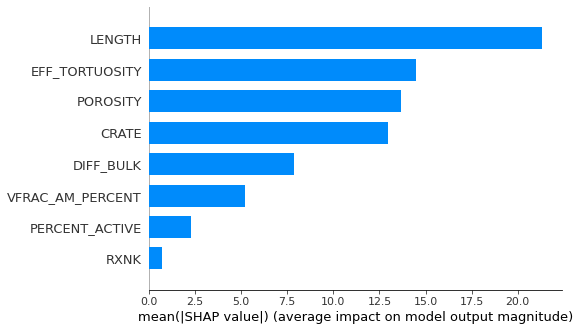

In [342]:
shap.summary_plot(shap_values, feature_names, plot_type="bar", title = 'SVR')

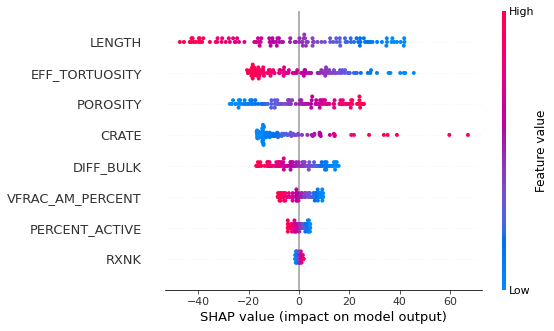

In [ ]:
shap.summary_plot(shap_values, test_x, feature_names = feature_names)

#Task 4: Grid Search for transformation combinations

In [8]:
# Adjust vairables to their relationships to target
best_ls = []
best_score = 0
best_mae = 0
for i in range(10000):
  ls = []
  dataset = data.copy()
  for j in range(COL_N):
    l = random.choice([-1, -1/2, 0, 1, 1/2])
    ls.append(l)
    if j == 3 or j == 7:
      dataset[: ,j] = boxcox(np.abs(data[: ,j]), lmbda = l)
    else:
      dataset[: ,j] = boxcox(data[: ,j], lmbda = l)

  scaled_X = (dataset - np.mean(dataset, axis = 0)) / np.std(dataset, axis = 0)
  train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(scaled_X, target, test_size = 0.1, random_state = 0)
  linear = sklearn.svm.SVR(kernel = 'linear')
  linear.fit(train_x, train_y)
  score = linear.score(test_x, test_y)
  yhat = linear.predict(test_x)
  mae = mean_absolute_error(test_y, yhat)
  if score > best_score:
    best_score = score
    best_ls = ls
    best_mae = mae

Text(0.5, 0, 'predicted y')

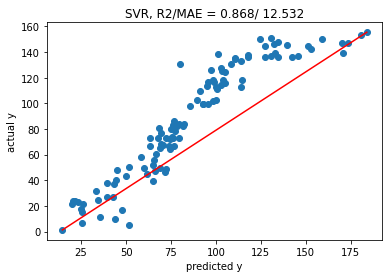

In [14]:
# plot best 
data2 = data.copy()
for i in range(COL_N):
  if i == 3 or i == 7:
    data2[: ,i] = boxcox(np.abs(data[: ,i]), lmbda = best_ls[i])
  else:
    data2[: ,i] = boxcox(data[: ,i], lmbda = best_ls[i])
second_scaled_X = (data2 - np.mean(data2, axis = 0)) / np.std(data2, axis = 0)

train_x2, test_x2, train_y2, test_y2 = sklearn.model_selection.train_test_split(second_scaled_X, target, test_size = 0.1, random_state = 0)
linear2 = sklearn.svm.SVR(kernel = 'linear')
linear2.fit(train_x2, train_y2)
score2 = linear2.score(test_x2, test_y2)
yhat2 = linear2.predict(test_x2)
mae2 = mean_absolute_error(test_y2, yhat2)

plt.scatter(yhat2, test_y2)
plt.plot(np.linspace(np.min(yhat2), np.max(yhat2)), np.linspace(np.min(test_y2), np.max(test_y2)), color ='r')
plt.title('SVR'+ ', R2/MAE = %.3f/ %.3f' % (score2, mae2))
plt.ylabel('actual y')
plt.xlabel('predicted y')


In [22]:
# Transformation visualization
original_ls = [1, 0, 1, 1, 0, 1, -1, 0]
best_trans = []
original_trans = []
pbook = {-1: 'reciprocal', 0: 'log', 1: 'none', -1/2: 'reciprocal square root', 1/2: 'square root'}
for i in range(COL_N):
  best_trans.append(pbook[best_ls[i]])
  original_trans.append(pbook[original_ls[i]])

trans_res = pd.DataFrame({'Feature name': feature_names, 'Our attempt': original_trans, 'Best grid search': best_trans})
trans_res.head(8)

,Feature name,Our attempt,Best grid search
0,PERCENT_ACTIVE,none,square root
1,EFF_TORTUOSITY,log,log
2,POROSITY,none,none
3,RXNK,none,reciprocal
4,VFRAC_AM_PERCENT,log,reciprocal
5,LENGTH,none,square root
6,CRATE,reciprocal,log
7,DIFF_BULK,log,square root
